In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Major project/X-Ray_Image_DataSet'

/content/drive/MyDrive/Major project/X-Ray_Image_DataSet


In [ ]:
ls

 best_model1.h5   Covid-19/               model_best.h5   Train/
 best_model4.h5   covid_adjusted/         modelvgg.h5     Valid/
 best_model5.h5   DarkNetTrain-3.pth      No_findings/
 best_model6.h5   k_fold_model_dense.h5   Pneumonia/
 best_model.h5    k_fold_model.h5        'three class'/


In [2]:
import numpy as np
import os
import time
# from resnet50 import ResNet50
from keras.preprocessing.image import load_img,img_to_array
# from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.vgg19 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split #cross-validation

In [ ]:
PATH = os.getcwd()
# Define data path
data_path = PATH
data_dir_list = os.listdir(data_path)
data_dir_list
data_dir_list
data_dir_list=['No_findings','Pneumonia','Covid-19']
data_dir_list

['No_findings', 'Pneumonia', 'Covid-19']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2, time
import tensorflow as tf

tf.__version__

'2.4.1'

not required

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
# from keras.applications.vgg19 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from pickle import dump
import os

covid_fold=[]
Pneumonia_fold=[]
normal_fold=[]
count=0
for dataset in data_dir_list:
  img_list=os.listdir(data_path+'/'+ dataset)
  print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
  for img in img_list:
    
    img_path =data_path+'/'+dataset + '/'+ img
    if dataset=='No_findings':
      normal_fold.append(img_path)
      # normal_labels.append(0)
    elif dataset=='Pneumonia':
      Pneumonia_fold.append(img_path)
      # Pneumonia_labels.append(1)
    elif dataset=='Covid-19':
      covid_fold.append(img_path)
      # covid_labels.append(2)
    count+=1
    if count%50==0:
      print(img_path," ",count)

Loaded the images of dataset-No_findings

/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00001281_000.png   50
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00003363_002.png   100
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00002679_000.png   150
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00001613_003.png   200
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00003130_004.png   250
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00002301_000.png   300
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00002577_000.png   350
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00003428_002.png   400
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00002633_005.png   450
/content/drive/MyDrive/Major project/X-Ray_Image_DataSet/No_findings/00003580_000.png   500
Loaded the images of dataset-Pneumonia


In [ ]:
fold_train=[]
fold_test=[]
prev1=0
prev2=0
prev3=0
for i in range(5):
  next1=int((len(covid_fold)/5)*(i+1))
  next2=int((len(normal_fold)/5)*(i+1))
  next3=int((len(Pneumonia_fold)/5)*(i+1))
  fold_train.append((covid_fold[:prev1]+covid_fold[next1:],normal_fold[:prev2]+normal_fold[next2:],Pneumonia_fold[:prev3]+Pneumonia_fold[next3:]))
  fold_test.append((covid_fold[prev1:next1],normal_fold[prev2:next2],Pneumonia_fold[prev3:next3]))

  
  prev1=next1
  prev2=next2
  prev3=next3


In [ ]:
len(fold_train)

5

In [3]:
%cd '/content/drive/MyDrive/Major project/FOLD/1'

/content/drive/.shortcut-targets-by-id/1dApjB8QlA_GPfkRWEbxHYkYhhdV8NlFz/Major project/FOLD/1


In [4]:
train_covid=[]
train_normal=[]
train_Pneumonia=[]
test_covid=[]
test_normal=[]
test_Pneumonia=[]

path='/content/drive/MyDrive/Major project/FOLD/5'
for img in os.listdir(path+'/Train/Covid-19'):
  img_path=path+'/Train/Covid-19/'+img
  train_covid.append(img_path)

for img in os.listdir(path+'/Train/No-findings'):
  img_path=path+'/Train/No-findings/'+img
  train_normal.append(img_path)

for img in os.listdir(path+'/Train/Pneumonia'):
  img_path=path+'/Train/Pneumonia/'+img
  train_Pneumonia.append(img_path) 

for img in os.listdir(path+'/Valid/Covid-19'):
  img_path=path+'/Valid/Covid-19/'+img
  test_covid.append(img_path)

for img in os.listdir(path+'/Valid/No-findings'):
  img_path=path+'/Valid/No-findings/'+img
  test_normal.append(img_path)

for img in os.listdir(path+'/Valid/Pneumonia'):
  img_path=path+'/Valid/Pneumonia/'+img
  test_Pneumonia.append(img_path)

#Preprocessing

In [5]:
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
# from keras.applications.vgg19 import preprocess_input
# from keras.applications.densenet import preprocess_input
# from keras.applications.resnet50 import preprocess_input
# from keras.applications.resnet import preprocess_input
# from keras.applications.inception_v3 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.xception import preprocess_input
from pickle import dump
import os

X_train=[]
X_test=[]
y_train=[]
y_test=[]

# train_covid,train_normal,train_Pneumonia=fold_train[4]
# test_covid,test_normal,test_Pneumonia=fold_test[4]

#covid
print("covid")
for img_path in train_covid:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Train/Covid-19'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_train.append(image)
  y_train.append(1)

for img_path in test_covid:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Valid/Covid-19'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_test.append(image)
  y_test.append(1)


#normal
print("normal")
for img_path in train_normal:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Train/No-findings'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_train.append(image)
  y_train.append(0)

for img_path in test_normal:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Valid/No-findings'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_test.append(image)
  y_test.append(0)


#Pneumonia
print("Pneumonia")
for img_path in train_Pneumonia:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Train/Pneumonia'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_train.append(image)
  y_train.append(2)

for img_path in test_Pneumonia:
  # !cp -R "$img_path" '/content/drive/MyDrive/Major project/FOLD++/5/Valid/Pneumonia'
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_test.append(image)
  y_test.append(2)

covid
normal
Pneumonia


In [6]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [7]:
X_train = X_train .astype('float32')
X_train=np.rollaxis(X_train,1,0)
X_train=X_train[0]
print (X_train.shape)

X_test =X_test .astype('float32')
X_test=np.rollaxis(X_test,1,0)
X_test=X_test[0]
print (X_test.shape)

(900, 299, 299, 3)
(225, 299, 299, 3)


In [ ]:
import random

c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)


c = list(zip(X_test, y_test))

random.shuffle(c)

X_test, y_test = zip(*c)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((500, 299, 299, 3), (125, 299, 299, 3), (500, 2), (125, 2))

#VGG19

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
channels = 3
nb_filters = 32
kernel_size = (2, 2)
# model = Sequential()



pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(3, activation='softmax', name='predictions')(x)
# x = Dense(3, activation='softmax', name='predictions')(pretrained_model.layers[-2].output)
# model2.add(Dense(3, activation='softmax'))
# model2 =Model(inputs=pretrained_model.input,outputs=x)
# model2 = tf.keras.Sequential([
#     model1,

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())


80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 3)                 12291     
Total params: 139,582,531
Trainable params: 119,558,147

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 15.5729 - accuracy: 0.9440
Epoch 00001: val_accuracy improved from -inf to 0.97600, saving model to best_model.h5
16/16 [==============================] - 29s 2s/step - loss: 15.5729 - accuracy: 0.9440 - val_loss: 1.3935 - val_accuracy: 0.9760
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9940
Epoch 00002: val_accuracy improved from 0.97600 to 0.98400, saving model to best_model.h5
16/16 [==============================] - 30s 2s/step - loss: 0.1668 - accuracy: 0.9940 - val_loss: 1.0386 - val_accuracy: 0.9840
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9980
Epoch 00003: val_accuracy did not improve from 0.98400
16/16 [==============================] - 24s 1s/step - loss: 0.0523 - accuracy: 0.9980 - val_loss: 0.7136 - val_accuracy: 0.9600
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.9920
Epo

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('modelvgg.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 41.5247 - accuracy: 0.6156
Epoch 00001: val_accuracy improved from -inf to 0.77778, saving model to modelvgg.h5
29/29 [==============================] - 55s 2s/step - loss: 41.5247 - accuracy: 0.6156 - val_loss: 0.9408 - val_accuracy: 0.7778
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 1.0005 - accuracy: 0.8700
Epoch 00002: val_accuracy improved from 0.77778 to 0.80000, saving model to modelvgg.h5
29/29 [==============================] - 52s 2s/step - loss: 1.0005 - accuracy: 0.8700 - val_loss: 0.9923 - val_accuracy: 0.8000
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9400
Epoch 00003: val_accuracy improved from 0.80000 to 0.83556, saving model to modelvgg.h5
29/29 [==============================] - 51s 2s/step - loss: 0.2375 - accuracy: 0.9400 - val_loss: 0.7626 - val_accuracy: 0.8356
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 

In [ ]:
from keras.models import load_model
model = load_model('best_model.h5')

In [ ]:
from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-3].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 4096), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

##Multi class results

vgg19

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 946ms/step - loss: 0.8215 - accuracy: 0.8533
test loss, test acc: [0.8214794397354126, 0.8533333539962769]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 901ms/step - loss: 1.5900 - accuracy: 0.8311
test loss, test acc: [1.5900486707687378, 0.8311111330986023]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 941ms/step - loss: 1.2419 - accuracy: 0.8356
test loss, test acc: [1.241930603981018, 0.8355555534362793]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 946ms/step - loss: 1.0596 - accuracy: 0.8444
test loss, test acc: [1.0595999956130981, 0.8444444537162781]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 992ms/step - loss: 0.8794 - accuracy: 0.8356
test loss, test acc: [0.8794365525245667, 0.8355555534362793]


In [ ]:
ACC=[0.8533333539962769,0.8311111330986023,0.8355555534362793,0.8444444537162781,0.8355555534362793]
sum(ACC)/5

0.8400000095367431

vgg19+svm multiclass

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8311111111111111

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8266666666666667

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8444444444444444

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8488888888888889

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8355555555555556

In [ ]:
ACC=[0.8311111111111111,0.8266666666666667,0.8444444444444444,0.8488888888888889,0.8355555555555556]
sum(ACC)/5

0.8373333333333333

-----

###Binary class results

vgg19

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 916ms/step - loss: 0.9134 - accuracy: 0.9920
test loss, test acc: [0.913385808467865, 0.9919999837875366]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 868ms/step - loss: 0.0042 - accuracy: 1.0000
test loss, test acc: [0.0042444802820682526, 1.0]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 854ms/step - loss: 0.1649 - accuracy: 0.9920
test loss, test acc: [0.16487206518650055, 0.9919999837875366]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 856ms/step - loss: 1.0517 - accuracy: 0.9760
test loss, test acc: [1.0517046451568604, 0.9760000109672546]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 941ms/step - loss: 3.0746e-05 - accuracy: 1.0000
test loss, test acc: [3.074615597142838e-05, 1.0]


In [ ]:
ACC=[0.9919999837875366,1.0,0.9919999837875366,0.9760000109672546,1.0]
sum(ACC)/5

0.9919999957084655

vgg19+svm binary

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.992

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.992

In [ ]:
ACC=[0.992,0.984,0.984,0.968,0.992]
sum(ACC)/5

0.984

----

#ResNet50 modified

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
# from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications.resnet50 import ResNet50
channels = 3



pretrained_model =ResNet50(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(2048, activation='relu', name='fc2')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
# x = Dense(3, activation='softmax', name='predictions')(pretrained_model.layers[-2].output)
# model2.add(Dense(3, activation='softmax'))
# model2 =Model(inputs=pretrained_model.input,outputs=x)
# model2 = tf.keras.Sequential([
#     model1,

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              205522944 
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 233,311,106
Trainable params: 209,723,394
Non-trainable params: 23,587,712
____________________________________

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_binary_4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 18s 913ms/step - loss: 55.6158 - accuracy: 0.7614 - val_loss: 2.5502 - val_accuracy: 0.9280

Epoch 00001: val_accuracy improved from -inf to 0.92800, saving model to best_model_binary_4.h5
Epoch 2/20
16/16 [==============================] - 13s 833ms/step - loss: 0.7507 - accuracy: 0.9667 - val_loss: 0.7756 - val_accuracy: 0.9680

Epoch 00002: val_accuracy improved from 0.92800 to 0.96800, saving model to best_model_binary_4.h5
Epoch 3/20
16/16 [==============================] - 13s 834ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.6385 - val_accuracy: 0.9680

Epoch 00003: val_accuracy did not improve from 0.96800
Epoch 4/20
16/16 [==============================] - 13s 844ms/step - loss: 0.0203 - accuracy: 0.9975 - val_loss: 0.6216 - val_accuracy: 0.9760

Epoch 00004: val_accuracy improved from 0.96800 to 0.97600, saving model to best_model_binary_4.h5
Epoch 5/20
16/16 [==============================] - 13s 847ms/step - loss:

In [ ]:
from keras.models import load_model
model = load_model('best_model_multi_1.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-3].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 2048), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    print(thresh)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        print(cm[i,j])
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

##MULTI CLASS RESULTS

ResNet50

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 422ms/step - loss: 0.8901 - accuracy: 0.8533
test loss, test acc: [0.8900546431541443, 0.8533333539962769]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       100
           1       1.00      0.92      0.96        25
           2       0.82      0.86      0.84       100

    accuracy                           0.85       225
   macro avg       0.89      0.87      0.88       225
weighted avg       0.86      0.85      0.85       225



Confusion matrix, without normalization
[[0.83 0.   0.17]
 [0.   0.92 0.08]
 [0.14 0.   0.86]]
0.46
0.83
0.0
0.17
0.0
0.92
0.08
0.14
0.0
0.86


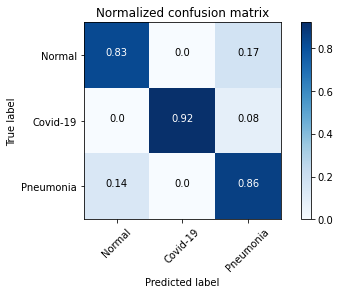

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=False)
    

In [ ]:
cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)
cm

array([[83,  0, 17],
       [ 0, 23,  2],
       [14,  0, 86]])

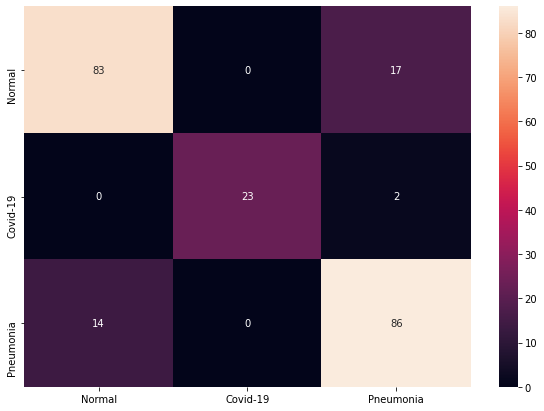

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


tmp=['Normal','Covid-19','Pneumonia']
df_cm = pd.DataFrame(cm, index = [i for i in tmp],
                  columns = [i for i in tmp])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Confusion matrix, without normalization
[[83  0 17]
 [ 0 23  2]
 [14  0 86]]


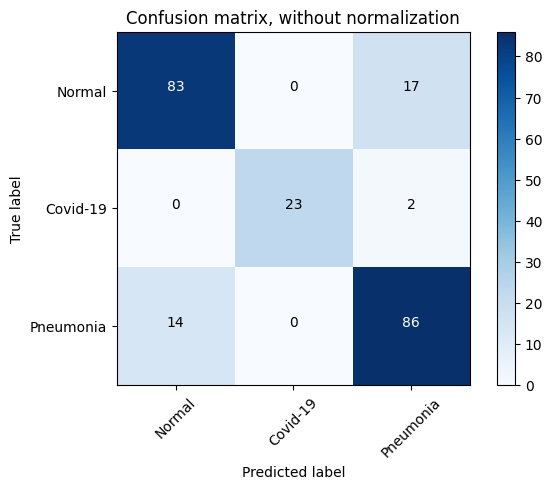

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
plt.figure(1,figsize=(4,3))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

NameError: ignored

None


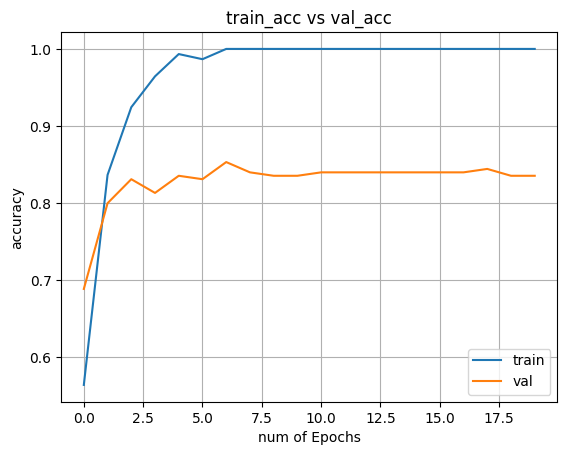

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 441ms/step - loss: 0.9076 - accuracy: 0.8711
test loss, test acc: [0.9076215028762817, 0.8711110949516296]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       100
           1       1.00      0.92      0.96        25
           2       0.92      0.78      0.84       100

    accuracy                           0.87       225
   macro avg       0.91      0.88      0.89       225
weighted avg       0.88      0.87      0.87       225



Normalized confusion matrix
[[0.95 0.   0.05]
 [0.   0.92 0.08]
 [0.22 0.   0.78]]


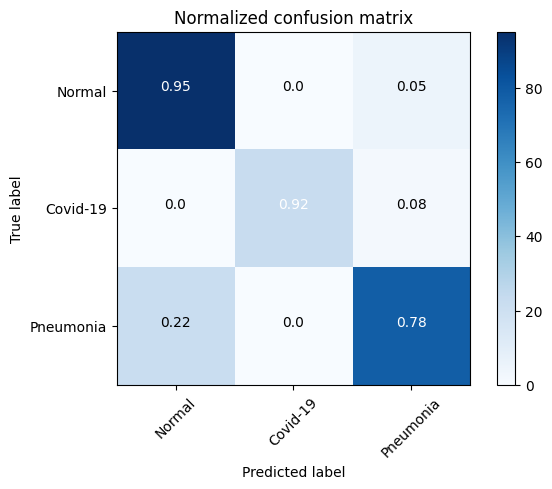

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[95  0  5]
 [ 0 23  2]
 [22  0 78]]


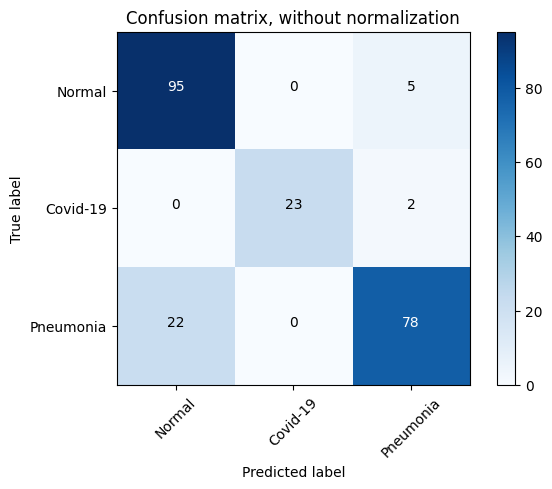

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


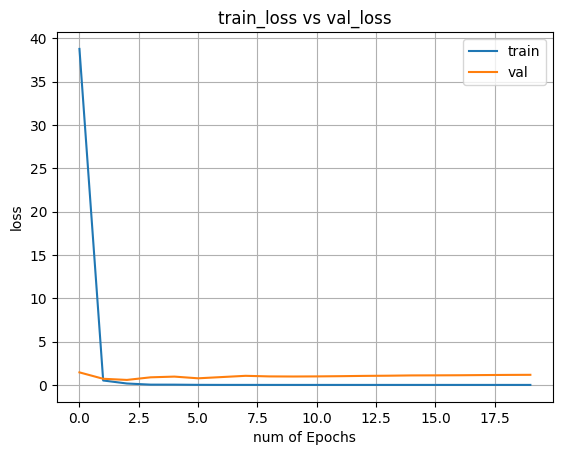

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


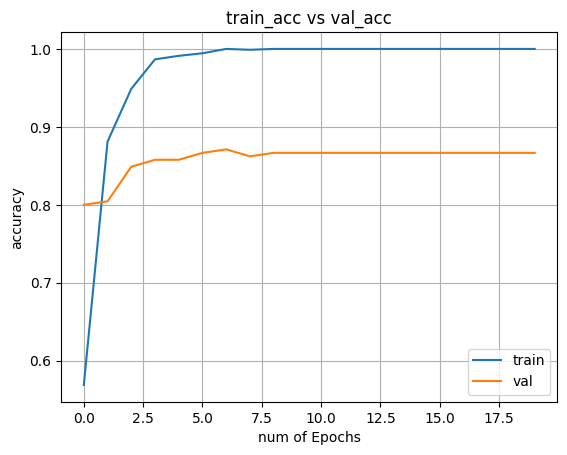

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 418ms/step - loss: 1.0615 - accuracy: 0.8756
test loss, test acc: [1.0615417957305908, 0.8755555748939514]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       100
           1       0.92      0.92      0.92        25
           2       0.86      0.88      0.87       100

    accuracy                           0.88       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.88      0.88      0.88       225



Normalized confusion matrix
[[0.86 0.02 0.12]
 [0.   0.92 0.08]
 [0.12 0.   0.88]]


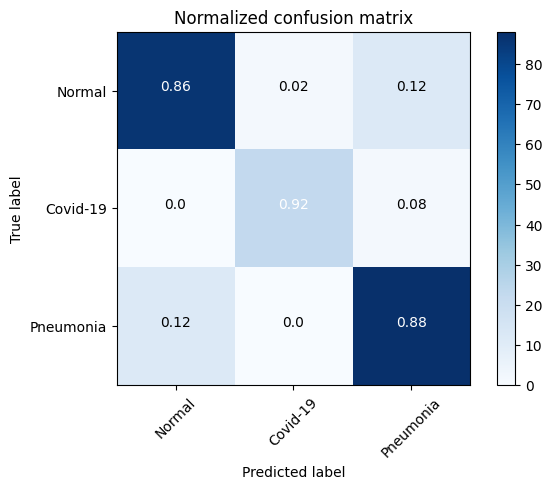

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[86  2 12]
 [ 0 23  2]
 [12  0 88]]


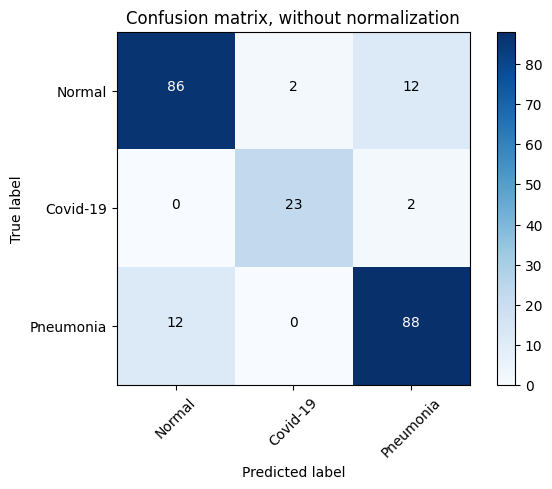

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


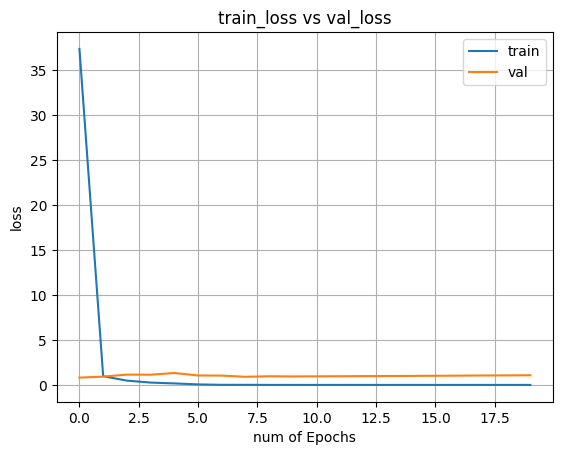

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


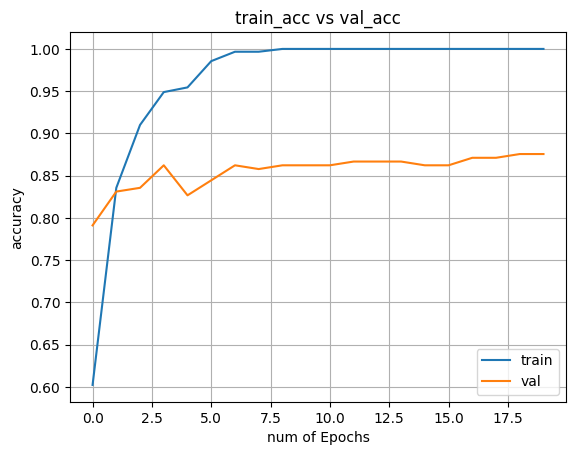

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 480ms/step - loss: 1.0146 - accuracy: 0.8667
test loss, test acc: [1.0145890712738037, 0.8666666746139526]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       100
           1       0.89      0.96      0.92        25
           2       0.87      0.83      0.85       100

    accuracy                           0.87       225
   macro avg       0.87      0.89      0.88       225
weighted avg       0.87      0.87      0.87       225



Normalized confusion matrix
[[0.88 0.   0.12]
 [0.04 0.96 0.  ]
 [0.14 0.03 0.83]]


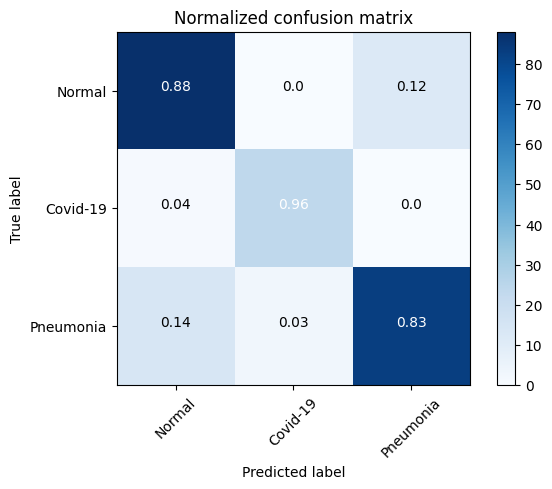

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[88  0 12]
 [ 1 24  0]
 [14  3 83]]


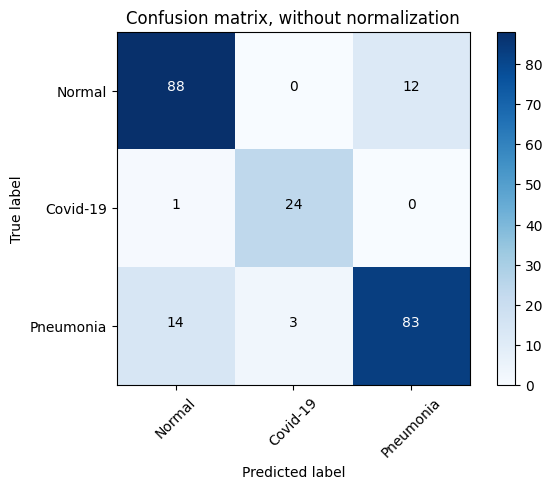

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


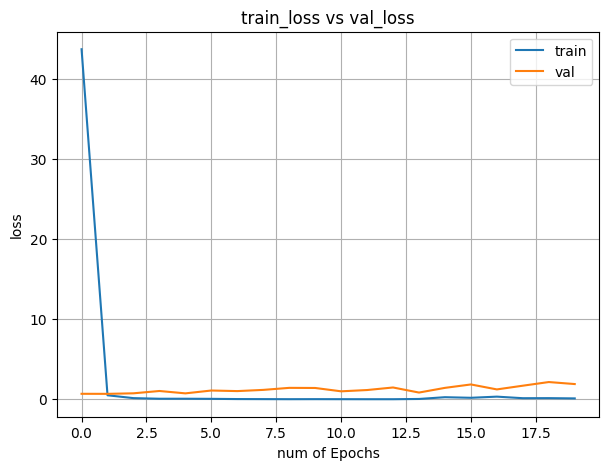

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


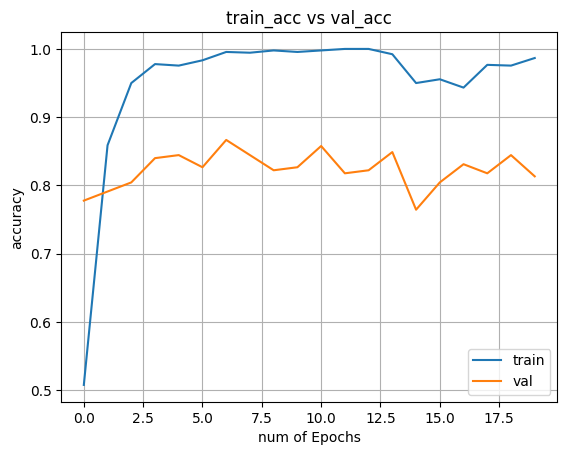

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 455ms/step - loss: 0.8694 - accuracy: 0.8400
test loss, test acc: [0.8693844079971313, 0.8399999737739563]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       100
           1       0.88      0.88      0.88        25
           2       0.81      0.83      0.82       100

    accuracy                           0.84       225
   macro avg       0.85      0.85      0.85       225
weighted avg       0.84      0.84      0.84       225



Normalized confusion matrix
[[0.84 0.   0.16]
 [0.   0.88 0.12]
 [0.14 0.03 0.83]]


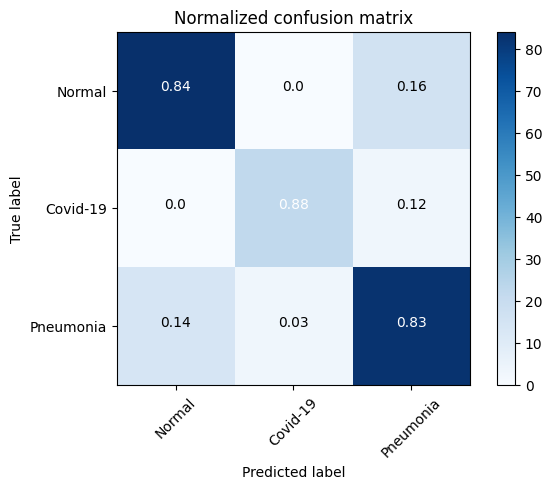

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[84  0 16]
 [ 0 22  3]
 [14  3 83]]


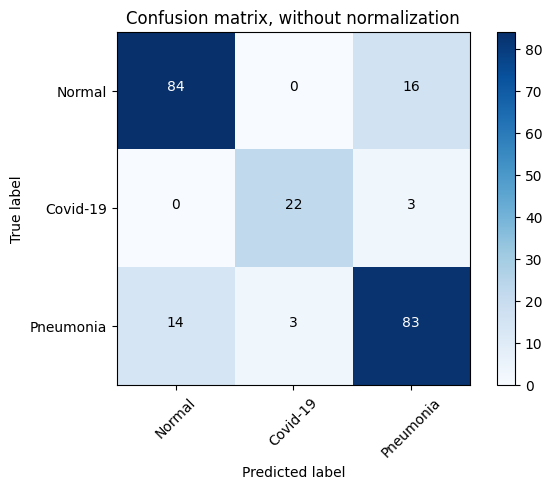

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19','Pneumonia'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


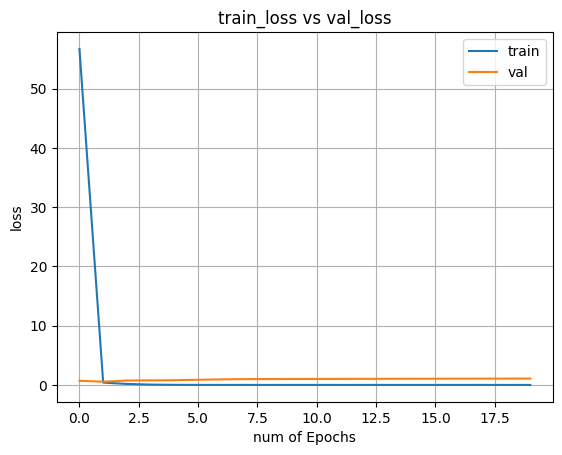

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


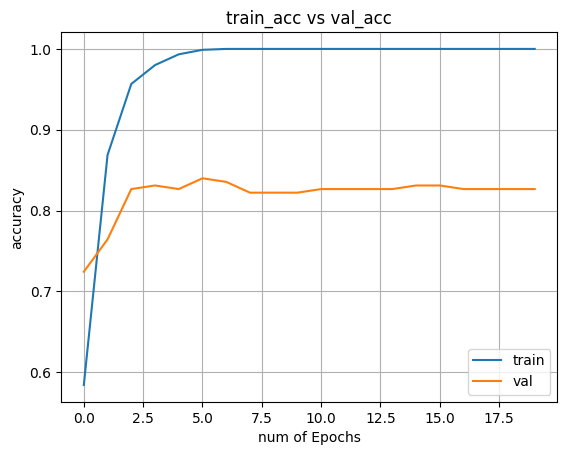

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

In [ ]:
ACC=[0.8533333539962769,0.8711110949516296,0.8755555748939514,0.8666666746139526,0.8399999737739563]
sum(ACC)/5

0.8613333344459534

ResNet50+svm for multiclass


1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8266666666666667

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8311111111111111

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8888888888888888

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8755555555555555

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8488888888888889

In [ ]:
ACC=[0.8266666666666667,0.8311111111111111,0.8888888888888888,0.8755555555555555,0.8488888888888889]
sum(ACC)/5

0.8542222222222223

-----

##Binary class

ResNet50

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 418ms/step - loss: 0.4386 - accuracy: 0.9920
test loss, test acc: [0.4386121332645416, 0.9919999837875366]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.96      0.98        25

    accuracy                           0.99       125
   macro avg       1.00      0.98      0.99       125
weighted avg       0.99      0.99      0.99       125



Normalized confusion matrix
[[1.   0.  ]
 [0.04 0.96]]


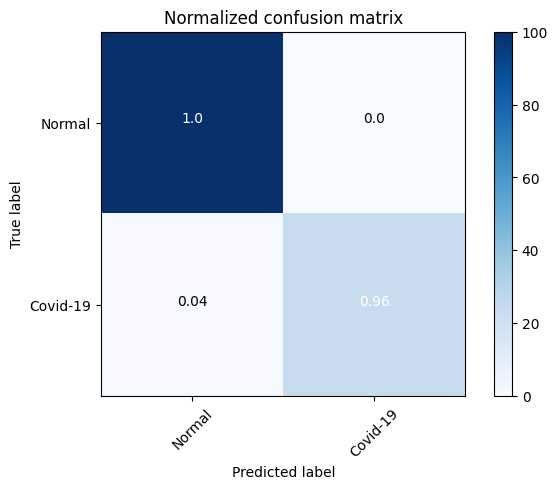

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[100   0]
 [  1  24]]


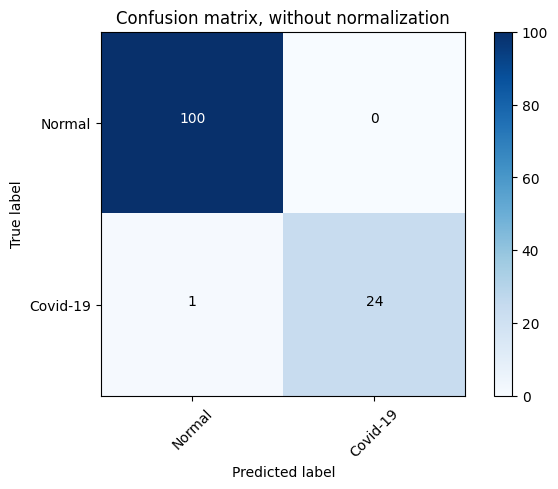

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


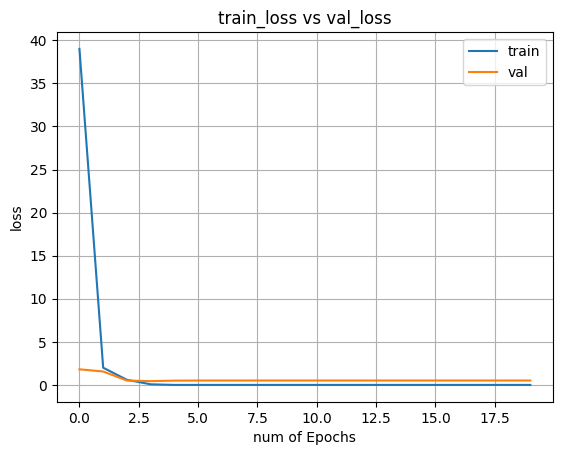

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(4,3))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


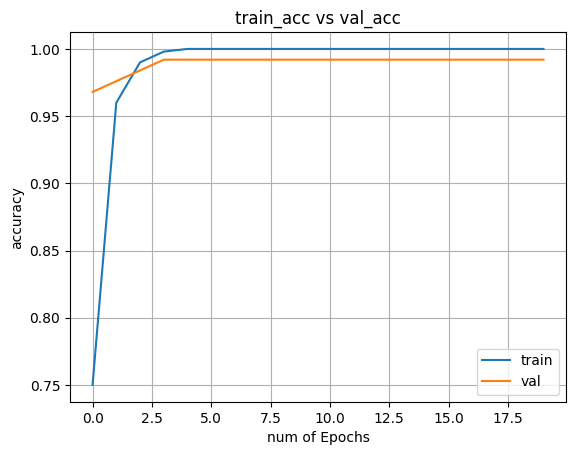

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 2s 410ms/step - loss: 1.7882e-04 - accuracy: 1.0000
test loss, test acc: [0.00017881658277474344, 1.0]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.96      0.98        25

    accuracy                           0.99       125
   macro avg       1.00      0.98      0.99       125
weighted avg       0.99      0.99      0.99       125



Normalized confusion matrix
[[1.   0.  ]
 [0.04 0.96]]


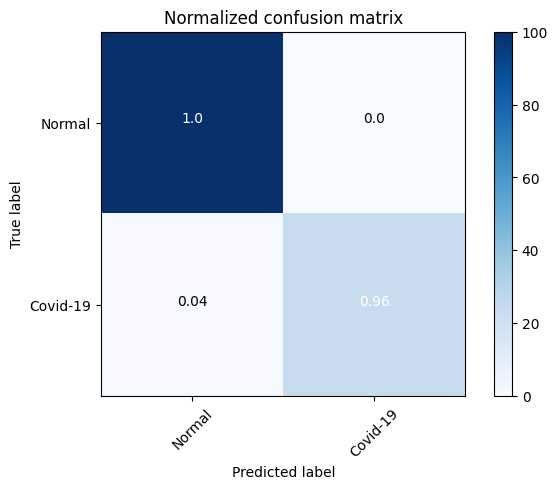

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[100   0]
 [  1  24]]


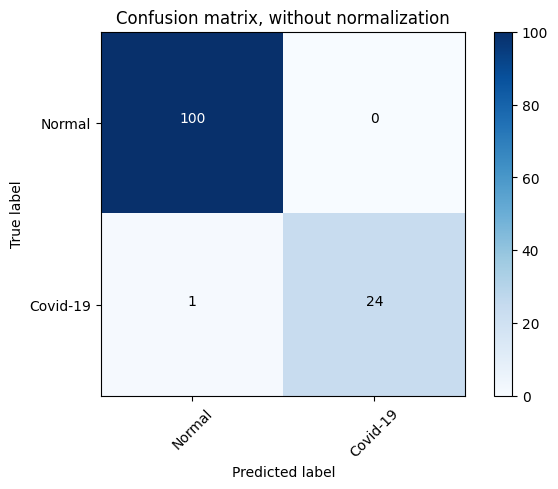

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


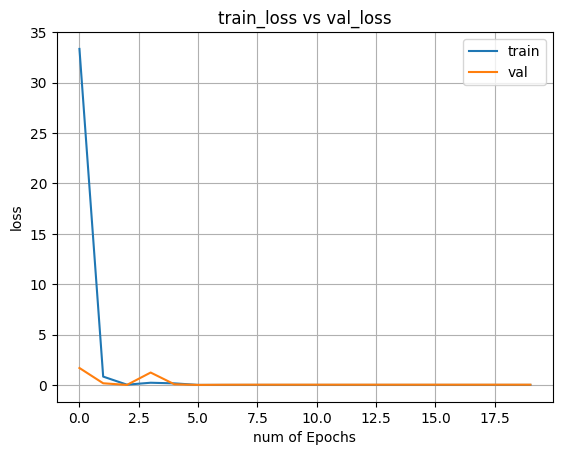

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(4,3))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


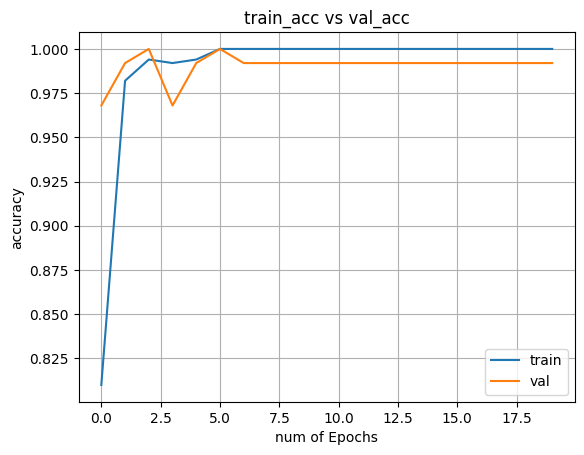

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 425ms/step - loss: 4.0054e-08 - accuracy: 1.0000
test loss, test acc: [4.00542568002038e-08, 1.0]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


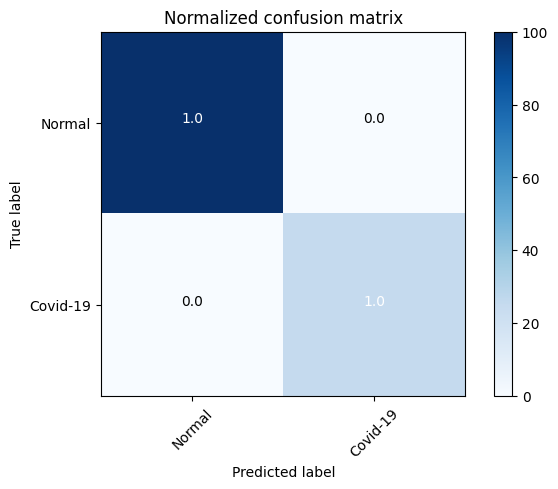

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[100   0]
 [  0  25]]


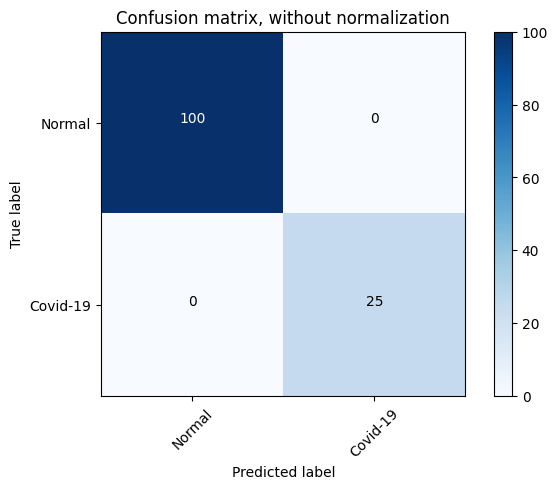

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


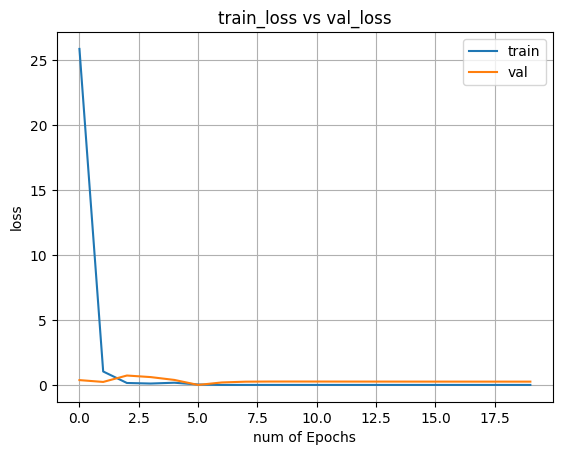

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(4,3))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


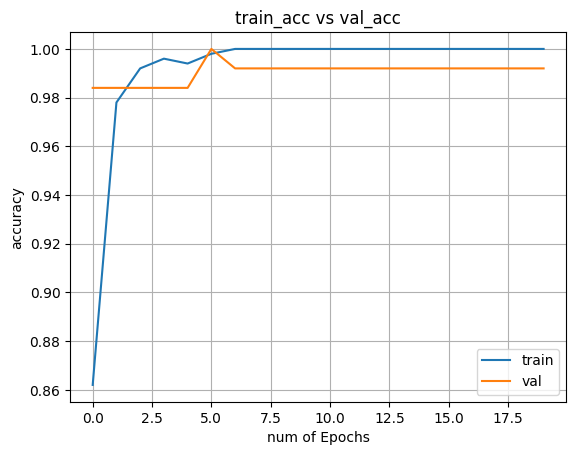

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 506ms/step - loss: 0.6216 - accuracy: 0.9760
test loss, test acc: [0.6216017603874207, 0.9760000109672546]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.84      0.91        25

    accuracy                           0.97       125
   macro avg       0.98      0.92      0.95       125
weighted avg       0.97      0.97      0.97       125



Normalized confusion matrix
[[1.   0.  ]
 [0.16 0.84]]


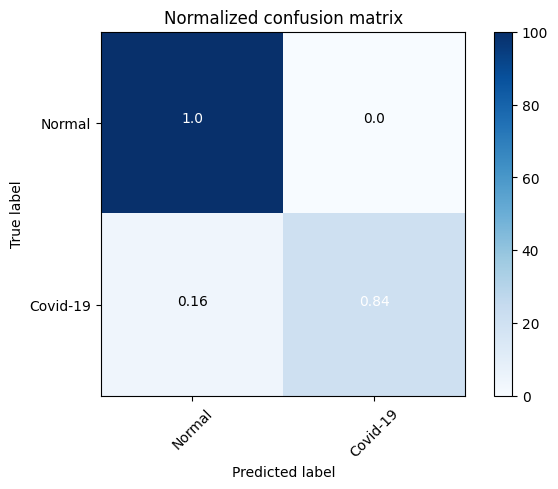

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[100   0]
 [  4  21]]


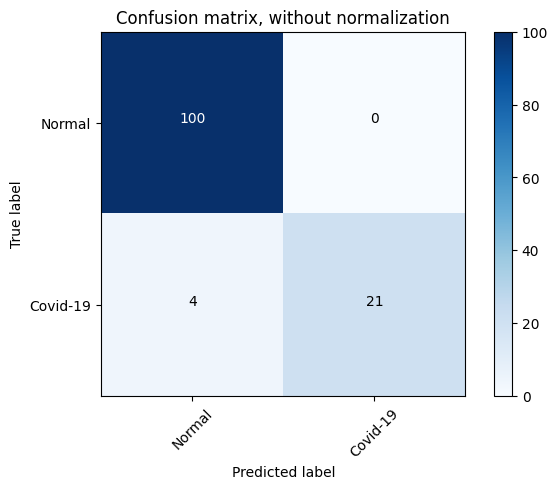

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


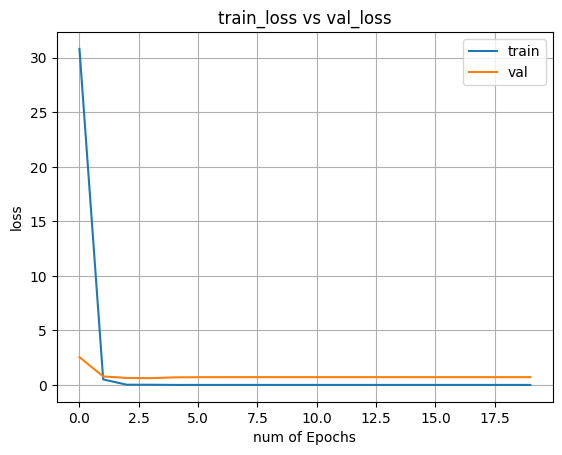

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
# plt.figure(1,figsize=(4,3))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


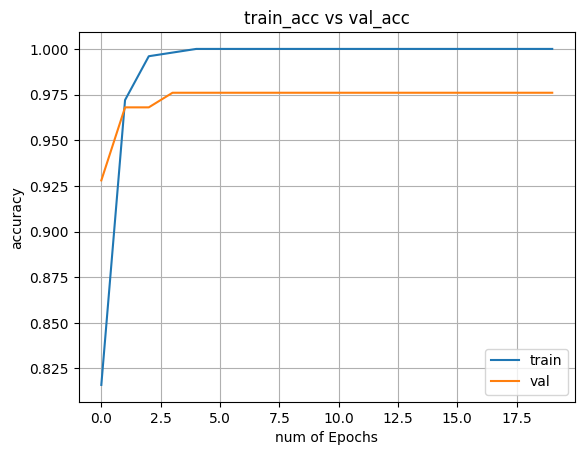

In [ ]:
# plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 501ms/step - loss: 0.1414 - accuracy: 0.9920
test loss, test acc: [0.14138656854629517, 0.9919999837875366]


In [ ]:
from sklearn import metrics
import numpy as np
y_pred=np.around(model.predict(X_test))
y_test1= np.argmax(y_test, axis=1)
y_pred1= np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.96      1.00      0.98        25

    accuracy                           0.99       125
   macro avg       0.98      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



Normalized confusion matrix
[[0.99 0.01]
 [0.   1.  ]]


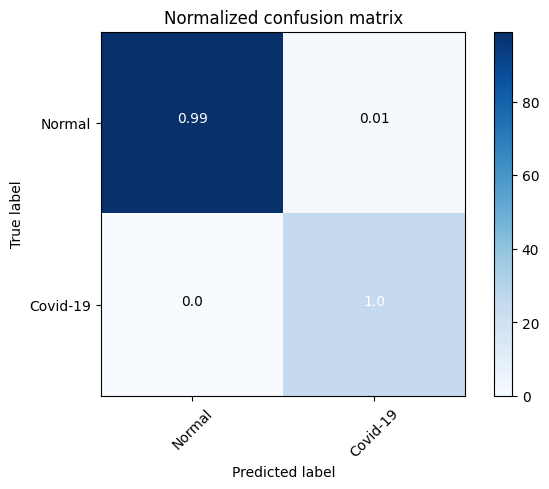

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test1, y_pred=y_pred1)


plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Normalized confusion matrix',
                      normalize=True)
    

Confusion matrix, without normalization
[[99  1]
 [ 0 25]]


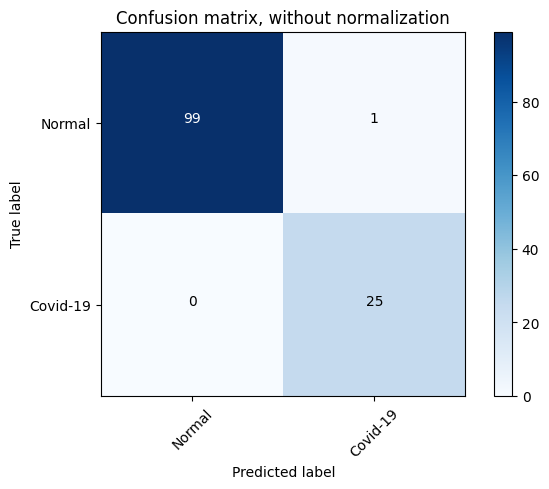

In [ ]:
plot_confusion_matrix(cm=cm, 
                      classes=['Normal','Covid-19'],
                      cmap=plt.cm.Blues,
                      title='Confusion matrix, without normalization',
                      normalize=False)

None


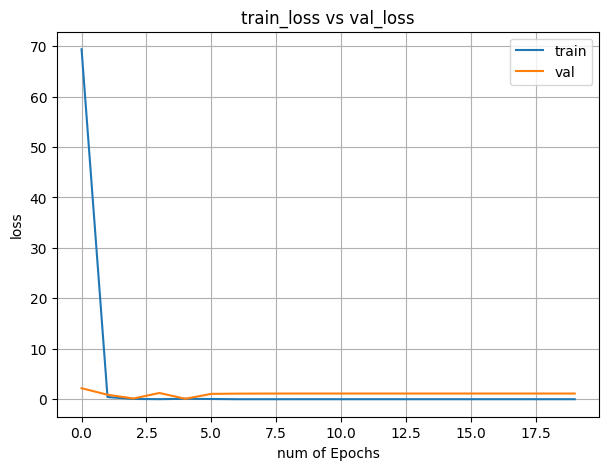

In [ ]:
import matplotlib.pyplot as plt
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(20)
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

None


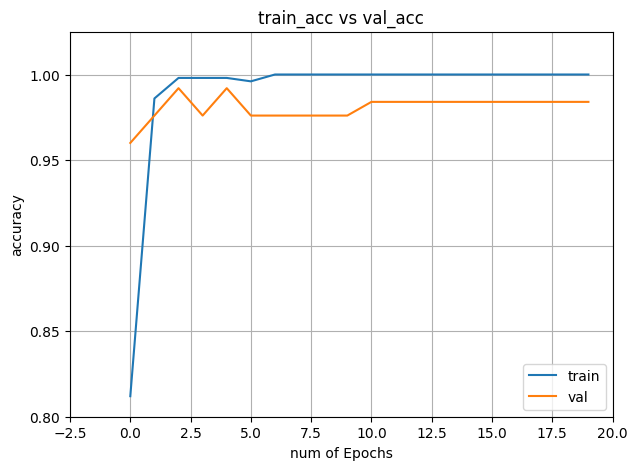

In [ ]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
print(plt.style.use(['default']))

In [ ]:
ACC=[0.9919999837875366,1.0,1.0,0.9760000109672546,0.9919999837875366]
sum(ACC)/5

0.9919999957084655

ResNet50+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.992

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

1.0

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

In [ ]:
ACC=[0.984,0.992,1.0,0.968,0.984]
sum(ACC)/5

0.9856

-----

In [ ]:
from keras.applications.resnet50 import ResNet50
mod=ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
mod.layers[-6].output

<tf.Tensor 'conv5_block3_3_conv/BiasAdd:0' shape=(None, 7, 7, 2048) dtype=float32>

#RESNet50 ACTUAL


In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications.resnet50 import ResNet50
channels = 3



pretrained_model =ResNet50(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
x = pretrained_model(keras_input)

#Add the fully-connected layers 
x =GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
# x = Dense(3, activation='softmax', name='predictions')(pretrained_model.layers[-2].output)
# model2.add(Dense(3, activation='softmax'))
# model2 =Model(inputs=pretrained_model.input,outputs=x)
# model2 = tf.keras.Sequential([
#     model1,

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

Model: "functional_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8200
Epoch 00001: val_accuracy improved from -inf to 0.88000, saving model to best_model4.h5
16/16 [==============================] - 11s 660ms/step - loss: 0.4546 - accuracy: 0.8200 - val_loss: 0.2982 - val_accuracy: 0.8800
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9160
Epoch 00002: val_accuracy improved from 0.88000 to 0.95200, saving model to best_model4.h5
16/16 [==============================] - 10s 616ms/step - loss: 0.2391 - accuracy: 0.9160 - val_loss: 0.1835 - val_accuracy: 0.9520
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9500
Epoch 00003: val_accuracy did not improve from 0.95200
16/16 [==============================] - 9s 584ms/step - loss: 0.1567 - accuracy: 0.9500 - val_loss: 0.1464 - val_accuracy: 0.9520
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.

In [ ]:
from keras.models import load_model
model = load_model('best_model4.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

###Multiclass results

resnet50

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 3s 337ms/step - loss: 0.4223 - accuracy: 0.8400
test loss, test acc: [0.42225366830825806, 0.8399999737739563]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 3s 351ms/step - loss: 0.4313 - accuracy: 0.8267
test loss, test acc: [0.43130549788475037, 0.8266666531562805]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 3s 327ms/step - loss: 0.3168 - accuracy: 0.8933
test loss, test acc: [0.3167901635169983, 0.8933333158493042]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 3s 335ms/step - loss: 0.3508 - accuracy: 0.8711
test loss, test acc: [0.3508172035217285, 0.8711110949516296]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 3s 328ms/step - loss: 0.3825 - accuracy: 0.8578
test loss, test acc: [0.38245537877082825, 0.8577777743339539]


In [ ]:
ACC=[0.8400,0.8267,0.8933,0.8711,0.8578]
sum(ACC)/5

0.85778

resnet50+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8177777777777778

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8133333333333334

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8488888888888889

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8533333333333334

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8533333333333334

In [ ]:
ACC=[0.8177777777777778,0.8133333333333334,0.8488888888888889,0.8533333333333334,0.8533333333333334]
sum(ACC)/5

0.8373333333333333

###Binary

resnet

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 308ms/step - loss: 0.0758 - accuracy: 0.9840
test loss, test acc: [0.07583002001047134, 0.984000027179718]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 334ms/step - loss: 0.0680 - accuracy: 0.9920
test loss, test acc: [0.06798510998487473, 0.9919999837875366]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 321ms/step - loss: 0.0756 - accuracy: 0.9920
test loss, test acc: [0.07558839023113251, 0.9919999837875366]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 326ms/step - loss: 0.1637 - accuracy: 0.9600
test loss, test acc: [0.16369573771953583, 0.9599999785423279]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 368ms/step - loss: 0.0773 - accuracy: 0.9840
test loss, test acc: [0.07734374701976776, 0.984000027179718]


In [ ]:
ACC=[0.9840,0.9920,0.9920,0.9600,0.9840]
sum(ACC)/5

0.9823999999999999

resnet+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.96

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.96

In [ ]:
ACC=[0.976,0.968,0.976,0.96,0.96]
sum(ACC)/5

0.968

#DenseNet121

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
# from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications import DenseNet121


channels = 3
pretrained_model =DenseNet121(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
x = pretrained_model(keras_input)

#Add the fully-connected layers 
x =GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)


model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 2,050
Non-trainable params: 7,037,504
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('desnet121_model_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 19s 839ms/step - loss: 0.5897 - accuracy: 0.6733 - val_loss: 0.4824 - val_accuracy: 0.8000

Epoch 00001: val_accuracy improved from -inf to 0.80000, saving model to desnet121_model_b.h5
Epoch 2/20
16/16 [==============================] - 13s 794ms/step - loss: 0.3977 - accuracy: 0.8113 - val_loss: 0.4075 - val_accuracy: 0.8000

Epoch 00002: val_accuracy did not improve from 0.80000
Epoch 3/20
16/16 [==============================] - 11s 716ms/step - loss: 0.3475 - accuracy: 0.8473 - val_loss: 0.3506 - val_accuracy: 0.8400

Epoch 00003: val_accuracy improved from 0.80000 to 0.84000, saving model to desnet121_model_b.h5
Epoch 4/20
16/16 [==============================] - 11s 701ms/step - loss: 0.3073 - accuracy: 0.9137 - val_loss: 0.3109 - val_accuracy: 0.8560

Epoch 00004: val_accuracy improved from 0.84000 to 0.85600, saving model to desnet121_model_b.h5
Epoch 5/20
16/16 [==============================] - 11s 715ms/step - loss: 0.2503

In [ ]:
from keras.models import load_model
model = load_model('desnet121_model_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

##Mulitclass results

desnet121

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 6s 487ms/step - loss: 0.4498 - accuracy: 0.8044
test loss, test acc: [0.4498000741004944, 0.804444432258606]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 490ms/step - loss: 0.4989 - accuracy: 0.7911
test loss, test acc: [0.49886125326156616, 0.7911111116409302]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 6s 545ms/step - loss: 0.4470 - accuracy: 0.8133
test loss, test acc: [0.44698333740234375, 0.8133333325386047]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 497ms/step - loss: 0.4315 - accuracy: 0.8444
test loss, test acc: [0.431520938873291, 0.8444444537162781]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 6s 536ms/step - loss: 0.4498 - accuracy: 0.8356
test loss, test acc: [0.4498239755630493, 0.8355555534362793]


In [ ]:
ACC=[0.804444432258606,0.7911111116409302,0.8133333325386047,0.8444444537162781,0.8355555534362793]
sum(ACC)/5

0.8177777767181397

desnet121+SVM


1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8133333333333334

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7688888888888888

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7866666666666666

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8133333333333334

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8355555555555556

In [ ]:
ACC=[0.8133333333333334,0.7688888888888888,0.7866666666666666,0.8133333333333334,0.8355555555555556]
sum(ACC)/5

0.8035555555555556

## Binary results

densenet121

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 505ms/step - loss: 0.1323 - accuracy: 0.9680
test loss, test acc: [0.13233910501003265, 0.9679999947547913]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 507ms/step - loss: 0.1593 - accuracy: 0.9600
test loss, test acc: [0.1593419760465622, 0.9599999785423279]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 550ms/step - loss: 0.1633 - accuracy: 0.9680
test loss, test acc: [0.1632896363735199, 0.9679999947547913]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 595ms/step - loss: 0.1414 - accuracy: 0.9440
test loss, test acc: [0.1413685381412506, 0.9440000057220459]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 573ms/step - loss: 0.1355 - accuracy: 0.9520
test loss, test acc: [0.13552755117416382, 0.9520000219345093]


In [ ]:
ACC=[0.9679999947547913,0.9599999785423279,0.9679999947547913,0.9440000057220459,0.9520000219345093]
sum(ACC)/5

0.9583999991416932

densenet121+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.96

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.952

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.952

In [ ]:
ACC=[0.96,0.968,0.976,0.952,0.952]
sum(ACC)/5

0.9616

# Covid-Net

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
# from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications.resnet_v2 import ResNet50V2





pretrained_model =ResNet50V2(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)


model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              102761472 
_________________________________________________________________
fc2 (Dense)                  (None, 256)               262400    
_________________________________________________________________
predictions (Dense)          (None, 2)                 514       
Total params: 126,589,186
Trainable params: 103,024,386
Non-trainable params: 23,564,800
___________________________________

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('covidnet_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 15s 692ms/step - loss: 1841.2936 - accuracy: 0.8570 - val_loss: 254.3333 - val_accuracy: 0.9360

Epoch 00001: val_accuracy improved from -inf to 0.93600, saving model to covidnet_b.h5
Epoch 2/20
16/16 [==============================] - 10s 654ms/step - loss: 520.4931 - accuracy: 0.9405 - val_loss: 409.6006 - val_accuracy: 0.9120

Epoch 00002: val_accuracy did not improve from 0.93600
Epoch 3/20
16/16 [==============================] - 10s 660ms/step - loss: 248.0558 - accuracy: 0.9475 - val_loss: 110.9344 - val_accuracy: 0.9440

Epoch 00003: val_accuracy improved from 0.93600 to 0.94400, saving model to covidnet_b.h5
Epoch 4/20
16/16 [==============================] - 11s 672ms/step - loss: 91.4763 - accuracy: 0.9667 - val_loss: 151.0846 - val_accuracy: 0.9200

Epoch 00004: val_accuracy did not improve from 0.94400
Epoch 5/20
16/16 [==============================] - 12s 760ms/step - loss: 60.5899 - accuracy: 0.9606 - val_loss: 86.0045

In [ ]:
from keras.models import load_model
model = load_model('covidnet_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-3].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 1024), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

## Multiclass results

Covidnet

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 430ms/step - loss: 173.0300 - accuracy: 0.7244
test loss, test acc: [173.0299835205078, 0.7244444489479065]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 430ms/step - loss: 237.4312 - accuracy: 0.7556
test loss, test acc: [237.43124389648438, 0.7555555701255798]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 408ms/step - loss: 233.2281 - accuracy: 0.7467
test loss, test acc: [233.2281494140625, 0.746666669845581]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 419ms/step - loss: 102.8035 - accuracy: 0.7778
test loss, test acc: [102.80351257324219, 0.7777777910232544]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 358ms/step - loss: 229.2867 - accuracy: 0.7378
test loss, test acc: [229.2867431640625, 0.7377777695655823]


In [ ]:
ACC=[0.7244444489479065,0.7555555701255798,0.746666669845581,0.7777777910232544,0.7377777695655823]
sum(ACC)/5

0.7484444499015808

Covidnet+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7066666666666667

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7511111111111111

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7555555555555555

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7466666666666667

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7244444444444444

In [ ]:
ACC=[0.7066666666666667,0.7511111111111111,0.7555555555555555,0.7466666666666667,0.7244444444444444]
sum(ACC)/5

0.7368888888888889

## Binary results

covidnet

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 441ms/step - loss: 111.2249 - accuracy: 0.9600
test loss, test acc: [111.22486877441406, 0.9599999785423279]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 413ms/step - loss: 289.0216 - accuracy: 0.9600
test loss, test acc: [289.0216064453125, 0.9599999785423279]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 2s 413ms/step - loss: 102.6894 - accuracy: 0.9680
test loss, test acc: [102.68943786621094, 0.9679999947547913]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 2s 400ms/step - loss: 309.3754 - accuracy: 0.9520
test loss, test acc: [309.3753662109375, 0.9520000219345093]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 422ms/step - loss: 66.6822 - accuracy: 0.9680
test loss, test acc: [66.6821517944336, 0.9679999947547913]


In [ ]:
ACC=[0.9599999785423279,0.9599999785423279,0.9599999785423279,0.9359999895095825,0.9679999947547913]
sum(ACC)/5

0.9567999839782715

covidnet+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.928

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.944

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.896

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.944

In [ ]:
ACC=[0.928,0.944,0.976,0.896,0.944]
sum(ACC)/5

0.9376

# InceptioinV3

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.preprocessing import LabelEncoder
from keras.models import Model





pretrained_model = InceptionV3(weights='imagenet', include_top=False ,input_shape=[299, 299, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(299,299,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = GlobalAveragePooling2D()(output_vgg19_conv)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 23,903,010
Trainable params: 2,100,226
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('inceptionV3_model_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 16s 730ms/step - loss: 0.9332 - accuracy: 0.7200 - val_loss: 0.4518 - val_accuracy: 0.9120

Epoch 00001: val_accuracy improved from -inf to 0.91200, saving model to inceptionV3_model_b.h5
Epoch 2/20
16/16 [==============================] - 10s 639ms/step - loss: 0.3218 - accuracy: 0.8746 - val_loss: 0.2520 - val_accuracy: 0.9360

Epoch 00002: val_accuracy improved from 0.91200 to 0.93600, saving model to inceptionV3_model_b.h5
Epoch 3/20
16/16 [==============================] - 10s 647ms/step - loss: 0.1678 - accuracy: 0.9412 - val_loss: 0.1514 - val_accuracy: 0.9520

Epoch 00003: val_accuracy improved from 0.93600 to 0.95200, saving model to inceptionV3_model_b.h5
Epoch 4/20
16/16 [==============================] - 10s 611ms/step - loss: 0.0949 - accuracy: 0.9700 - val_loss: 0.1227 - val_accuracy: 0.9680

Epoch 00004: val_accuracy improved from 0.95200 to 0.96800, saving model to inceptionV3_model_b.h5
Epoch 5/20
16/16 [=============

In [ ]:
from keras.models import load_model
model = load_model('inceptionV3_model_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-3].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 2048), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

## Multiclass results

inceptionv3

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 403ms/step - loss: 0.5864 - accuracy: 0.7867
test loss, test acc: [0.5864462852478027, 0.7866666913032532]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 420ms/step - loss: 0.4602 - accuracy: 0.8178
test loss, test acc: [0.4601656496524811, 0.8177777528762817]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 404ms/step - loss: 0.4262 - accuracy: 0.8133
test loss, test acc: [0.42624783515930176, 0.8133333325386047]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 406ms/step - loss: 0.5618 - accuracy: 0.7956
test loss, test acc: [0.5617939829826355, 0.7955555319786072]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 5s 432ms/step - loss: 0.4806 - accuracy: 0.8222
test loss, test acc: [0.480636328458786, 0.8222222328186035]


In [ ]:
ACC=[0.7866666913032532,0.8177777528762817,0.8133333325386047,0.7955555319786072,0.8222222328186035]
sum(ACC)/5

0.8071111083030701

inceptionv3+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7466666666666667

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7822222222222223

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8133333333333334

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7555555555555555

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7777777777777778

In [ ]:
ACC=[0.7466666666666667,0.7822222222222223,0.8133333333333334,0.7555555555555555,0.7777777777777778]
sum(ACC)/5

0.7751111111111111

## Binary results

incptionv3

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 490ms/step - loss: 0.0507 - accuracy: 0.9840
test loss, test acc: [0.050749920308589935, 0.984000027179718]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 584ms/step - loss: 0.0271 - accuracy: 1.0000
test loss, test acc: [0.027124350890517235, 1.0]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 452ms/step - loss: 0.0656 - accuracy: 0.9840
test loss, test acc: [0.06561043858528137, 0.984000027179718]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 469ms/step - loss: 0.1051 - accuracy: 0.9760
test loss, test acc: [0.10511530935764313, 0.9760000109672546]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 3s 437ms/step - loss: 0.1717 - accuracy: 0.9760
test loss, test acc: [0.17173853516578674, 0.9760000109672546]


In [ ]:
ACC=[0.984000027179718,1.0,0.984000027179718,0.9760000109672546,0.9760000109672546]
sum(ACC)/5

0.9840000152587891

inceptionv3+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.944

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.928

In [ ]:
ACC=[0.976,0.976,0.968,0.944,0.928]
sum(ACC)/5

0.9583999999999999

# MoibleNetV2

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelEncoder
from keras.models import Model





pretrained_model = MobileNetV2(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = GlobalAveragePooling2D()(output_vgg19_conv)
x = Dense(1280, activation='relu')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
predictions (Dense)          (None, 2)                 2562      
Total params: 3,900,226
Trainable params: 1,642,242
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('mobilenetv2_model_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 8s 290ms/step - loss: 0.7802 - accuracy: 0.7677 - val_loss: 0.0770 - val_accuracy: 0.9840

Epoch 00001: val_accuracy improved from -inf to 0.98400, saving model to mobilenetv2_model_b.h5
Epoch 2/20
16/16 [==============================] - 4s 225ms/step - loss: 0.0584 - accuracy: 0.9934 - val_loss: 0.0427 - val_accuracy: 0.9840

Epoch 00002: val_accuracy did not improve from 0.98400
Epoch 3/20
16/16 [==============================] - 3s 199ms/step - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0270 - val_accuracy: 0.9920

Epoch 00003: val_accuracy improved from 0.98400 to 0.99200, saving model to mobilenetv2_model_b.h5
Epoch 4/20
16/16 [==============================] - 3s 192ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0248 - val_accuracy: 1.0000

Epoch 00004: val_accuracy improved from 0.99200 to 1.00000, saving model to mobilenetv2_model_b.h5
Epoch 5/20
16/16 [==============================] - 3s 213ms/step - loss: 0.010

In [ ]:
from keras.models import load_model
model = load_model('mobilenetv2_model_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-3].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 1280), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

## Multiclass results

mobilenetv2

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 166ms/step - loss: 0.3903 - accuracy: 0.8622
test loss, test acc: [0.3903021514415741, 0.8622221946716309]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 157ms/step - loss: 0.4371 - accuracy: 0.8489
test loss, test acc: [0.4371396601200104, 0.8488888740539551]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 147ms/step - loss: 0.3937 - accuracy: 0.8356
test loss, test acc: [0.39367440342903137, 0.8355555534362793]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 158ms/step - loss: 0.4431 - accuracy: 0.8356
test loss, test acc: [0.4430622458457947, 0.8355555534362793]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 2s 140ms/step - loss: 0.4064 - accuracy: 0.8400
test loss, test acc: [0.4063957929611206, 0.8399999737739563]


In [ ]:
ACC=[0.8622221946716309,0.8488888740539551,0.8355555534362793,0.8355555534362793,0.8399999737739563]
sum(ACC)/5

0.8444444298744201

mobilenetv2+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8355555555555556

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8488888888888889

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8533333333333334

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8355555555555556

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8311111111111111

In [ ]:
ACC=[0.8355555555555556,0.8488888888888889,0.8533333333333334,0.8355555555555556,0.8311111111111111]
sum(ACC)/5

0.8408888888888889

## Binary results

mobilenetV2

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 2s 185ms/step - loss: 0.0422 - accuracy: 0.9920
test loss, test acc: [0.042214203625917435, 0.9919999837875366]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 157ms/step - loss: 0.0224 - accuracy: 0.9920
test loss, test acc: [0.02243691496551037, 0.9919999837875366]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 144ms/step - loss: 0.0190 - accuracy: 1.0000
test loss, test acc: [0.018957464024424553, 1.0]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 138ms/step - loss: 0.0689 - accuracy: 0.9920
test loss, test acc: [0.06890887767076492, 0.9919999837875366]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 1s 138ms/step - loss: 0.0678 - accuracy: 0.9840
test loss, test acc: [0.06776650249958038, 0.984000027179718]


In [ ]:
ACC=[0.9919999837875366,0.9919999837875366,1.0,0.9919999837875366,0.984000027179718]
sum(ACC)/5

0.9919999957084655

mobilenetv2+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

In [ ]:
ACC=[0.976,0.976,0.984,0.984,0.984]
sum(ACC)/5

0.9808

# ResNet101

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications import ResNet101




pretrained_model =ResNet101(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
x = pretrained_model(keras_input)

#Add the fully-connected layers 
x =GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('resnet101_model_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 24s 1s/step - loss: 0.6585 - accuracy: 0.6886 - val_loss: 0.4445 - val_accuracy: 0.8720

Epoch 00001: val_accuracy improved from -inf to 0.87200, saving model to resnet101_model_b.h5
Epoch 2/20
16/16 [==============================] - 17s 1s/step - loss: 0.3538 - accuracy: 0.9127 - val_loss: 0.2418 - val_accuracy: 0.9040

Epoch 00002: val_accuracy improved from 0.87200 to 0.90400, saving model to resnet101_model_b.h5
Epoch 3/20
16/16 [==============================] - 17s 1s/step - loss: 0.1909 - accuracy: 0.9739 - val_loss: 0.2011 - val_accuracy: 0.9120

Epoch 00003: val_accuracy improved from 0.90400 to 0.91200, saving model to resnet101_model_b.h5
Epoch 4/20
16/16 [==============================] - 17s 1s/step - loss: 0.1271 - accuracy: 0.9674 - val_loss: 0.1469 - val_accuracy: 0.9520

Epoch 00004: val_accuracy improved from 0.91200 to 0.95200, saving model to resnet101_model_b.h5
Epoch 5/20
16/16 [==============================] -

In [ ]:
from keras.models import load_model
model = load_model('resnet101_model_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 2048), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

## Multiclass results

resnet101

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 9s 856ms/step - loss: 0.4225 - accuracy: 0.8356
test loss, test acc: [0.42253583669662476, 0.8355555534362793]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 742ms/step - loss: 0.3897 - accuracy: 0.8444
test loss, test acc: [0.38965079188346863, 0.8444444537162781]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 9s 854ms/step - loss: 0.3552 - accuracy: 0.8756
test loss, test acc: [0.3551570177078247, 0.8755555748939514]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 8s 768ms/step - loss: 0.4320 - accuracy: 0.8444
test loss, test acc: [0.4319712519645691, 0.8444444537162781]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 694ms/step - loss: 0.3713 - accuracy: 0.8444
test loss, test acc: [0.3713367283344269, 0.8444444537162781]


In [ ]:
ACC=[0.8355555534362793,0.8444444537162781,0.8755555748939514,0.8444444537162781,0.8444444537162781]
sum(ACC)/5

0.848888897895813

resnet101+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8222222222222222

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8533333333333334

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8755555555555555

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8311111111111111

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.84

In [ ]:
ACC=[0.8222222222222222,0.8533333333333334,0.8755555555555555,0.8311111111111111,0.84]
sum(ACC)/5

0.8444444444444444

## Binary results

resnet101

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 5s 729ms/step - loss: 0.0755 - accuracy: 0.9840
test loss, test acc: [0.07547734677791595, 0.984000027179718]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 5s 713ms/step - loss: 0.0562 - accuracy: 0.9840
test loss, test acc: [0.05619225278496742, 0.984000027179718]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 5s 806ms/step - loss: 0.0820 - accuracy: 0.9920
test loss, test acc: [0.08201628923416138, 0.9919999837875366]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 5s 795ms/step - loss: 0.0755 - accuracy: 0.9920
test loss, test acc: [0.07551746070384979, 0.9919999837875366]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 689ms/step - loss: 0.0428 - accuracy: 1.0000
test loss, test acc: [0.042824435979127884, 1.0]


In [ ]:
ACC=[0.984000027179718,0.984000027179718,0.9919999837875366,0.9919999837875366,1.0]
sum(ACC)/5

0.9904000043869019

resnet101+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.984

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.992

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.992

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

In [ ]:
ACC=[0.984,0.976,0.992,0.992,0.976]
sum(ACC)/5

0.984

# Xception

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from sklearn.preprocessing import LabelEncoder
from keras.models import Model





pretrained_model = Xception(weights='imagenet', include_top=False ,input_shape=[299, 299, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(299,299,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = GlobalAveragePooling2D()(output_vgg19_conv)
x = Dense(2, activation='sigmoid', name='predictions')(x)

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('xception_model_b.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - 22s 1s/step - loss: 0.5996 - accuracy: 0.6409 - val_loss: 0.5013 - val_accuracy: 0.8000

Epoch 00001: val_accuracy improved from -inf to 0.80000, saving model to xception_model_b.h5
Epoch 2/20
16/16 [==============================] - 15s 968ms/step - loss: 0.4336 - accuracy: 0.8141 - val_loss: 0.4006 - val_accuracy: 0.8000

Epoch 00002: val_accuracy did not improve from 0.80000
Epoch 3/20
16/16 [==============================] - 15s 958ms/step - loss: 0.3593 - accuracy: 0.8229 - val_loss: 0.3548 - val_accuracy: 0.8080

Epoch 00003: val_accuracy improved from 0.80000 to 0.80800, saving model to xception_model_b.h5
Epoch 4/20
16/16 [==============================] - 15s 970ms/step - loss: 0.3310 - accuracy: 0.8224 - val_loss: 0.3157 - val_accuracy: 0.8240

Epoch 00004: val_accuracy improved from 0.80800 to 0.82400, saving model to xception_model_b.h5
Epoch 5/20
16/16 [==============================] - 15s 961ms/step - loss: 0.2862 - acc

In [ ]:
from keras.models import load_model
model = load_model('xception_model_b.h5')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score
from keras.models import Model

FC_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)
x_train= FC_layer_model.predict(X_train)
x_test=FC_layer_model.predict(X_test)

In [ ]:
x_train.shape,y_train.shape

((500, 2048), (500, 2))

In [ ]:
y_train1= np.argmax(y_train, axis=1)
y_test1= np.argmax(y_test, axis=1)

## Multiclass results

xception

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 724ms/step - loss: 0.5722 - accuracy: 0.7556
test loss, test acc: [0.5721911191940308, 0.7555555701255798]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 767ms/step - loss: 0.5224 - accuracy: 0.7778
test loss, test acc: [0.5223584175109863, 0.7777777910232544]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 788ms/step - loss: 0.5424 - accuracy: 0.7956
test loss, test acc: [0.5423921942710876, 0.7955555319786072]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 798ms/step - loss: 0.5548 - accuracy: 0.7867
test loss, test acc: [0.5548216700553894, 0.7866666913032532]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 7s 737ms/step - loss: 0.4985 - accuracy: 0.7733
test loss, test acc: [0.4984622001647949, 0.7733333110809326]


In [ ]:
ACC=[0.7555555701255798,0.7777777910232544,0.7955555319786072,0.7866666913032532,0.7733333110809326]
sum(ACC)/5

0.7777777791023255

xception+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7644444444444445

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7733333333333333

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.8

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7511111111111111

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.7955555555555556

In [ ]:
ACC=[0.7644444444444445,0.7733333333333333,0.8,0.7511111111111111,0.7955555555555556]
sum(ACC)/5

0.776888888888889

## Binary results

xception

1

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 790ms/step - loss: 0.1773 - accuracy: 0.9680
test loss, test acc: [0.17734265327453613, 0.9679999947547913]


2

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 804ms/step - loss: 0.1926 - accuracy: 0.9440
test loss, test acc: [0.1926414668560028, 0.9440000057220459]


3

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 802ms/step - loss: 0.1244 - accuracy: 0.9840
test loss, test acc: [0.1243920549750328, 0.984000027179718]


4

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 790ms/step - loss: 0.1719 - accuracy: 0.9360
test loss, test acc: [0.17185677587985992, 0.9359999895095825]


5

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 4s 760ms/step - loss: 0.1520 - accuracy: 0.9440
test loss, test acc: [0.15202033519744873, 0.9440000057220459]


In [ ]:
ACC=[0.9679999947547913,0.9440000057220459,0.984000027179718,0.9359999895095825,0.9440000057220459]
sum(ACC)/5

0.9552000045776368

xception+svm

1

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.968

2

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

3

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

4

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.936

5

In [ ]:
from sklearn.svm import SVC


classifier = SVC()
classifier.fit(x_train, y_train1)


# Predicting the Test set results

y_pred = classifier.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test1,y_pred)

0.976

In [ ]:
ACC=[0.968,0.976,0.976,0.936,0.976]
sum(ACC)/5

0.9663999999999999

# Different Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Major project/CT'

/content/drive/MyDrive/Major project/CT


In [ ]:
file=open('/content/drive/MyDrive/Major project/CT/COVID/trainCT_COVID.txt','rb')
train_covid=file.readlines()
for i in range(len(train_covid)):
  train_covid[i]=train_covid[i].decode("utf-8").split("\n")[0]
file.close()

file=open('/content/drive/MyDrive/Major project/CT/COVID/testCT_COVID.txt','rb')
test_covid=file.readlines()
for i in range(len(test_covid)):
  test_covid[i]=test_covid[i].decode("utf-8").split("\n")[0]
file.close()

file=open('/content/drive/MyDrive/Major project/CT/COVID/valCT_COVID.txt','rb')
val_covid=file.readlines()
for i in range(len(val_covid)):
  val_covid[i]=val_covid[i].decode("utf-8").split("\n")[0]
file.close()

In [ ]:
file=open('/content/drive/MyDrive/Major project/CT/NonCOVID/trainCT_NonCOVID.txt','rb')
train_noncovid=file.readlines()
for i in range(len(train_noncovid)):
  train_noncovid[i]=(train_noncovid[i].decode("utf-8").split("\n")[0]).split("\r")[0]
file.close()

file=open('/content/drive/MyDrive/Major project/CT/NonCOVID/testCT_NonCOVID.txt','rb')
test_noncovid=file.readlines()
for i in range(len(test_noncovid)):
  test_noncovid[i]=(test_noncovid[i].decode("utf-8").split("\n")[0]).split("\r")[0]
file.close()

file=open('/content/drive/MyDrive/Major project/CT/NonCOVID/valCT_NonCOVID.txt','rb')
val_noncovid=file.readlines()
for i in range(len(val_noncovid)):
  val_noncovid[i]=(val_noncovid[i].decode("utf-8").split("\n")[0]).split("\r")[0]
file.close()

In [ ]:
import numpy as np
import os
import time
# from resnet50 import ResNet50
from keras.preprocessing.image import load_img,img_to_array
# from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.vgg19 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2, time
import tensorflow as tf

tf.__version__

'2.4.1'

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import os

X_train=[]
X_val=[]
X_test=[]
y_train=[]
y_val=[]
y_test=[]

COVID_path='/content/drive/MyDrive/Major project/CT/CT_COVID/'
NonCOVID_path='/content/drive/MyDrive/Major project/CT/CT_NonCOVID/'

print("COVID")
for img_path in train_covid:
  image = load_img(COVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_train.append(image)
  y_train.append(1)

for img_path in val_covid:
  image = load_img(COVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_val.append(image)
  y_val.append(1)


for img_path in test_covid:
  image = load_img(COVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_test.append(image)
  y_test.append(1)


print("Non COVID")
for img_path in train_noncovid:
  image = load_img(NonCOVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_train.append(image)
  y_train.append(0)


for img_path in val_noncovid:
  image = load_img(NonCOVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_val.append(image)
  y_val.append(0)


for img_path in test_noncovid:
  image = load_img(NonCOVID_path+img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  X_test.append(image)
  y_test.append(0)


COVID
Non COVID


In [ ]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
X_train = X_train .astype('float32')
X_train=np.rollaxis(X_train,1,0)
X_train=X_train[0]
print (X_train.shape)

X_val = X_val .astype('float32')
X_val=np.rollaxis(X_val,1,0)
X_val=X_val[0]
print (X_val.shape)

X_test =X_test .astype('float32')
X_test=np.rollaxis(X_test,1,0)
X_test=X_test[0]
print (X_test.shape)

(425, 224, 224, 3)
(118, 224, 224, 3)
(203, 224, 224, 3)


In [ ]:
import random

c = list(zip(X_train, y_train))
random.shuffle(c)
X_train, y_train = zip(*c)


c = list(zip(X_val, y_val))
random.shuffle(c)
X_val, y_val = zip(*c)


c = list(zip(X_test, y_test))
random.shuffle(c)
X_test, y_test = zip(*c)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape

((425, 224, 224, 3),
 (118, 224, 224, 3),
 (203, 224, 224, 3),
 (425, 2),
 (118, 2),
 (203, 2))

In [ ]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import np_utils
# from keras.utils import multi_gpu_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.applications.resnet50 import ResNet50
channels = 3



pretrained_model =ResNet50(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_model.trainable = False
keras_input = Input(shape=(224,224,3), name = 'image_input')
    
#Use the generated model 
output_vgg19_conv = pretrained_model(keras_input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg19_conv)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(2048, activation='relu', name='fc2')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)

model2 = Model(inputs=keras_input, outputs=x)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              205522944 
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 233,311,106
Trainable params: 209,723,394
Non-trainable params: 23,587,712
____________________________________

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('different_D.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
hist = model2.fit(X_train,y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_val, y_val),callbacks=[es, mc])

Epoch 1/20
14/14 [==============================] - 15s 909ms/step - loss: 44.4630 - accuracy: 0.4747 - val_loss: 9.0726 - val_accuracy: 0.5508

Epoch 00001: val_accuracy improved from -inf to 0.55085, saving model to different_D.h5
Epoch 2/20
14/14 [==============================] - 11s 830ms/step - loss: 2.5649 - accuracy: 0.8226 - val_loss: 1.9640 - val_accuracy: 0.6864

Epoch 00002: val_accuracy improved from 0.55085 to 0.68644, saving model to different_D.h5
Epoch 3/20
14/14 [==============================] - 11s 824ms/step - loss: 0.2129 - accuracy: 0.9481 - val_loss: 1.4967 - val_accuracy: 0.7542

Epoch 00003: val_accuracy improved from 0.68644 to 0.75424, saving model to different_D.h5
Epoch 4/20
14/14 [==============================] - 12s 879ms/step - loss: 0.0412 - accuracy: 0.9922 - val_loss: 2.3454 - val_accuracy: 0.7542

Epoch 00004: val_accuracy did not improve from 0.75424
Epoch 5/20
14/14 [==============================] - 11s 808ms/step - loss: 0.0469 - accuracy: 0.99

In [ ]:
from keras.models import load_model
model = load_model('different_D.h5')

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 4s 444ms/step - loss: 1.5528 - accuracy: 0.7833
test loss, test acc: [1.5527554750442505, 0.7832512259483337]


In [ ]:
print("Evaluate on test data")
results = model2.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 3s 449ms/step - loss: 3.8034 - accuracy: 0.7685
test loss, test acc: [3.803439140319824, 0.7684729099273682]
